# AlgebraicRelations Workflow → Schema example
### Purpose
This notebook provides an example of how an SQL schema can be directly generated from the definition of a workflow in AlgebraicRelations. Using AlgebraicRelations in this allows for queries to be generated in terms of the processes in the defined workflow.

In [1]:
# We begin by importing necessary libraries
using AlgebraicRelations.DB
using AlgebraicRelations.Queries
using AlgebraicRelations.Presentations
using AlgebraicRelations.Interface

## Generating Workflow
The workflow is defined by types of objects and processes used within the workflow. The types are those of any objects that are generated and passed between the processes of the workflow.

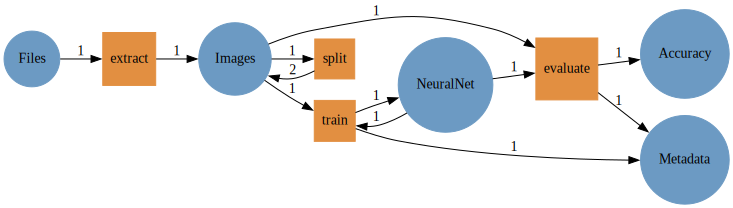

In [2]:
# Initialize presentation object
present = Presentation()

# Add types to presentation
Files, Images, NeuralNet,
       Accuracy, Metadata = add_types!(present, [(:Files, String),
                                            (:Images, String),
                                            (:NeuralNet, String),
                                            (:Accuracy, Real),
                                            (:Metadata, String)]);

# Add Processes to presentation
extract, split, train, evaluate = add_processes!(present, [(:extract, Files, Images),
                                                      (:split, Images, Images⊗Images),
                                                      (:train, NeuralNet⊗Images, NeuralNet⊗Metadata),
                                                      (:evaluate, NeuralNet⊗Images, Accuracy⊗Metadata)]);
# Convert to Schema
@present_to_schema TrainDB(present);
draw_schema(present)

In [3]:
print(generate_schema_sql(TrainDB()))

CREATE TABLE evaluate (NeuralNet1 text, Images2 text, Accuracy3 real, Metadata4 text);
CREATE TABLE extract (Files1 text, Images2 text);
CREATE TABLE split (Images1 text, Images2 text, Images3 text);
CREATE TABLE train (NeuralNet1 text, Images2 text, NeuralNet3 text, Metadata4 text);

## Visualizing Workflow
While this visualization currently does not play a role in defining the schema, it can be useful to visually ensure that every piece of the workflow is included.

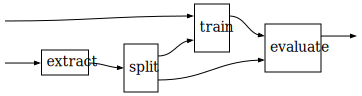

In [4]:
p = @program present (nn::NeuralNet, file::Files) begin
    images = extract(file)
    im_train, im_test = split(images)
    trained_nn, _ = train(nn, im_train)
    acc, _ = evaluate(trained_nn, im_test)
    return acc
end;
draw_workflow(p)

### ACSet-defined schema
The backend of AlgebraicRelations stores the schema as an ACSet (generalized database defined in Catlab.jl). The ACSet generated above looks like the following:
```julia
@present TrainingSchema <: TheorySQL begin
    # Tables
    split::Ob
    extract::Ob
    train::Ob
    evaluate::Ob
    
    # Columns of tables
    extract_1_Files1::Attr(extract, String)
    extract_2_Images2::Attr(extract, String)
    
    split_1_Images1::Attr(split, String)
    split_2_Images2::Attr(split, String)
    split_3_Images3::Attr(split, String)
    
    train_1_NeuralNet1::Attr(train, NeuralNet)
    train_2_Images2::Attr(train, Images)
    train_3_NeuralNet3::Attr(train, NeuralNet)
    train_4_Metadata4::Attr(train, Metadata)
    
    evaluate_1_NeuralNet1::Attr(evaluate, NeuralNet)
    evaluate_2_Images2::Attr(evaluate, Images)
    evaluate_3_Accuracy3::Attr(evaluate, Accuracy)
    evaluate_4_Metadata4::Attr(evaluate, Metadata)
end;
```

## Constructing Queries

Queries are constructed by providing the appropriate Schema, the objects to be returned, and the objects that are needed in the query. In the `where` statement, we define the types of each object (based on the workflow definition). We then use the processes in the workflow along with comparison operators to construct a query based on relationships between objects.

The following query will create a query which generates a table containing all neural network structures, sets of images they were trained, and their accuracies on the test images which performed higher than some base accuracy (`_base_acc`).

SELECT t1.Images2 AS im_train, t1.NeuralNet1 AS nn, t2.Images2 AS im_test, t2.Accuracy3 AS acc, t2.Metadata4 AS md2
FROM train AS t1, evaluate AS t2, split AS t3
WHERE t2.NeuralNet1=t1.NeuralNet3 AND t3.Images2=t1.Images2 AND t3.Images3=t2.Images2 AND t2.Accuracy3>=$1

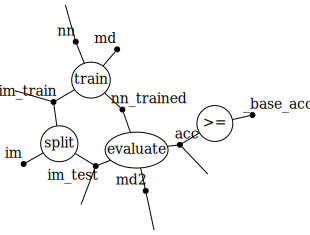

In [5]:
q = @query TrainDB() (im_train, nn, im_test, acc, md2) where (im_train, im_test, nn,
                                                              nn_trained, acc, md,
                                                              md2, _base_acc, im) begin
    train(nn, im_train, nn_trained, md)
    evaluate(nn_trained, im_test, acc, md2)
    split(im, im_train, im_test)
    >=(acc, _base_acc)
end
print(to_sql(q))
draw_query(q)

# Querying a PostgreSQL database
AlgebraicRelations also provides an interface with `LibPQ.jl` which allows us to query a database directly using the query object. Below is an example of the use of this interface.

For this to work make sure you have a Postgres instance running with a `test_wf` database (running `createdb test_wf`) and with the following dataset
```sql
DELETE FROM train; DELETE FROM evaluate; DELETE FROM split; 
INSERT INTO train VALUES ('nn_struc/struct1', 'im_tr_1', 'nn_struc/struct1'); 
INSERT INTO evaluate VALUES ('nn_struc/struct1', 'im_te_1', 0.9, 'md_ev_3'); 
INSERT INTO split VALUES ('im_1', 'im_tr_1', 'im_te_1');
INSERT INTO train VALUES ('nn_struc/struct2', 'im_tr_2', 'nn_struc/struct2'); 
INSERT INTO evaluate VALUES ('nn_struc/struct2', 'im_te_2', 0.8, 'md_ev_5'); 
INSERT INTO split VALUES ('im_2', 'im_tr_2', 'im_te_2');
```

In [6]:
conn = Connection("dbname=test_wf");

In [7]:
statement1 = prepare(conn,q);

In [8]:
execute(statement1, [0.6])

Row,im_train,nn,im_test,acc,md2
,String?,String?,String?,Float32?,String?
1,im_tr_1,nn_struc/struct1,im_te_1,0.9,md_ev_3
2,im_tr_2,nn_struc/struct2,im_te_2,0.8,md_ev_5
